# Security Evaluation Curves with Minimum-Norm Attacks


In this tutorial, we will learn how to evaluate the robustness of a model across a continuous range of perturbation thresholds using **Minimum-Norm Attacks**.

Unlike fixed-budget attacks (e.g., PGD), which evaluate robustness at a single specific radius $\varepsilon$, minimum-norm attacks aim to find the **smallest** perturbation required to produce a misclassification. Collecting these minimal distances for a dataset, it is possible to plot the **Security Evaluation Curve**. This curve is defined as:

$$
\rho(\varepsilon) = \frac{1}{N} \sum_{i=1}^N \mathbb{1}[d_i > \varepsilon]
$$

where:
- $N$ is the number of samples;
- $d_i$ is the minimal adversarial perturbation distance found for sample $i$;
- $\mathbb{1}[\cdot]$ is the indicator function.
The curve $\rho(\varepsilon)$ represents the fraction of samples that remain correctly classified (i.e., robust) when subjected to perturbations of size up to $\varepsilon$.

<div style="text-align:center">
  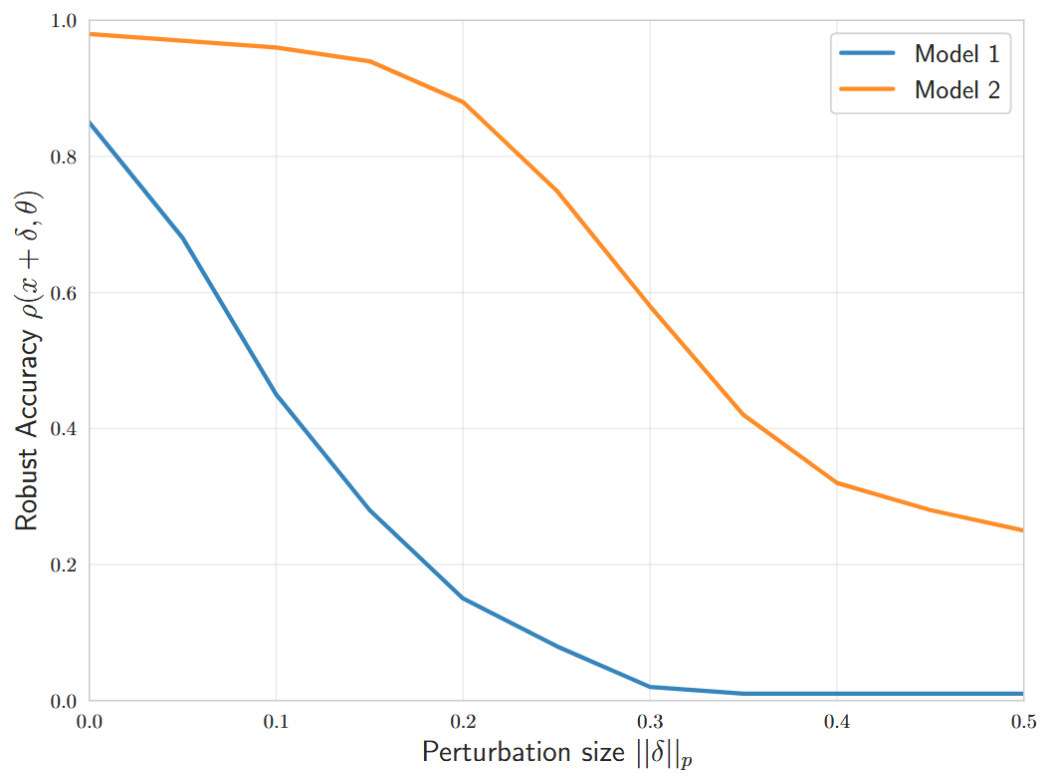
</div>

The picture above represents the evolution of two different models' robust accuracy as the perturbation radius $\varepsilon$ increases. At $\varepsilon=0$, the robust accuracy equals the clean accuracy (accuracy on unperturbed samples). As $\varepsilon$ increases, the robust accuracy typically decreases, reflecting the models' vulnerability to larger perturbations.

This curve could also be used to:
- Compare different models' robustness across all perturbation sizes;
- Evaluate the effectiveness of two (or more) attacks when evaluating adversarial robustness on a fixed model.

In this tutorial, we will evaluate the robustness curve on a basic CNN trained on MNIST. We will use the **Fast Minimum-Norm (FMN)** attack and `secml-torch` trackers to extract these distances and visualize the curve.


## Setup and Installation
First, we verify that `secml-torch` is installed and import the necessary libraries.


In [517]:
%%capture --no-stdout --no-stderr
try:
    import secmlt
except ImportError:
    %pip install git+https://github.com/pralab/secml-torch

In [518]:
%%capture
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Subset
from torch.optim import Adam
from utils.models import MNISTModel
from secmlt.models.pytorch.base_pytorch_nn import BasePytorchClassifier
from secmlt.models.pytorch.base_pytorch_trainer import BasePyTorchTrainer
from secmlt.metrics.classification import Accuracy
from secmlt.adv.backends import Backends
from secmlt.adv.evasion.fmn import FMN
from secmlt.adv.evasion.perturbation_models import LpPerturbationModels
from secmlt.trackers.trackers import (
    BestPerturbationNormTracker,
    PerturbationNormTracker,
)
from secmlt.utils.security_evaluation_curve_utils import (
    compute_security_evaluation_curve,
)

In [519]:
# Set device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


## Model Training
We define a simple Convolutional Neural Network (CNN) for MNIST and train it using the `BasePyTorchTrainer`.


In [520]:
# Load Dataset and DataLoaders
transform = transforms.Compose([transforms.ToTensor()])

train_dataset = torchvision.datasets.MNIST(
    root="./data", train=True, download=True, transform=transform
)
test_dataset = torchvision.datasets.MNIST(
    root="./data", train=False, download=True, transform=transform
)

# Subset sizes for faster tutorial runs
num_test_samples = 200 if device == "cuda" else 20
num_train_samples = 800 if device == "cuda" else 80

train_subset = Subset(train_dataset, list(range(num_train_samples)))
test_subset = Subset(test_dataset, list(range(num_test_samples)))

# DataLoader settings
train_loader = DataLoader(
    train_subset,
    batch_size=50,
    shuffle=True,
)

test_loader = DataLoader(
    test_subset,
    batch_size=num_test_samples,
    shuffle=False,
)

In [521]:
# Instantiate Model and Trainer
net = MNISTModel().to(device)
optimizer = Adam(net.parameters(), lr=1e-3)
trainer = BasePyTorchTrainer(optimizer=optimizer, epochs=5)

# Wrap model with SecML-Torch
model = BasePytorchClassifier(model=net, trainer=trainer)

In [522]:
# Train the model
print("Training model...")
model.train(train_loader)
print("Training complete.")

Training model...
Training complete.


In [523]:
# Evaluate clean accuracy
model.model.eval()
clean_acc = Accuracy()(model, test_loader)
print(f"Clean Test Accuracy: {clean_acc.item():.2%}")

Clean Test Accuracy: 93.00%


## Running Min-Norm Attacks (FMN)

To generate the robustness curve, we need the **minimal perturbation distance** for each sample.

We will use the **Fast Minimum-Norm (FMN)** attack, which dynamically adjusts the perturbation size to find the boundary between the correct and incorrect classification. We will use the $\ell_2$ norm as our perturbation model.

To capture the distances found during the attack, `secml-torch` rely on two main trackers:
- `PerturbationNormTracker`, which records the perturbation norm at the final step of the attack.
- `BestPerturbationNormTracker`, which records the smallest perturbation norm found during the entire attack process.



In [534]:
# Configure the attack
p = LpPerturbationModels.LINF
steps = 200
step_size = 0.5

trackers = [
    BestPerturbationNormTracker(p),  # Best distances found during attack iterations
    PerturbationNormTracker(p),  # Final distances at the end of the attack
]

attack = FMN(
    perturbation_model=p,
    num_steps=steps,
    step_size=step_size,
    backend=Backends.NATIVE,
    trackers=trackers,
)

In [535]:
print("Running FMN attack...")
adv_loader = attack(model, test_loader)
print("Attack completed.")

Running FMN attack...
Attack completed.


In [536]:
# Compute robust accuracy at the end of the attack process
final_robust_accuracy = Accuracy()(model, adv_loader)
print(f"Robust Accuracy at the end of the attack: {final_robust_accuracy:.2%}")

Robust Accuracy at the end of the attack: 0.00%


##  Computing and Plotting the Security Evaluation Curve

Once the attack has been performed, we can extract the recorded perturbation distances $d_i$ for every sample $x_i$ in test set from the trackers.

We use the helper function `compute_robust_accuracy_curve` from `secmlt.utils.robustness_curve_utils`.
This function takes the tensor of distances (with shape `[num_samples, num_steps]`) and calculates the robust accuracy for a sorted list of $\varepsilon$ thresholds.

Then, we are able to plot the security evaluation curve by using the `matplotlib` library.


In [537]:
# Collect best per-sample perturbation distances from the tracker
best_distances = attack.trackers[0].get()
adv_distances = attack.trackers[1].get()

# Compute curves
best_dist_unique, robust_acc = compute_security_evaluation_curve(adv_distances, p=p)
adv_dist_unique, adv_robust_acc = compute_security_evaluation_curve(best_distances, p=p)

Finally, we visualize the results:

- The **X-axis** represents the perturbation budget ($\varepsilon$).
- The **Y-axis** represents the Robust Accuracy $\rho(\varepsilon)$ (percentage of samples correctly classified within that budget).


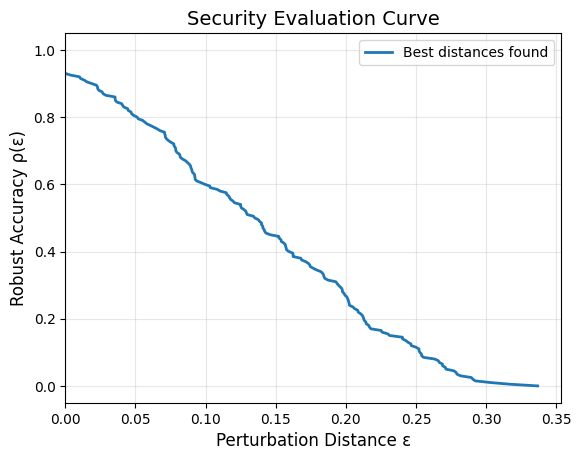

In [544]:
# Plot L2 Curve with best distances
plt.plot(
    best_dist_unique,
    robust_acc,
    label=f"Best distances found",
    color="tab:blue",
    linewidth=2,
)
plt.xlabel("Perturbation Distance ε", fontsize=12)
plt.ylabel("Robust Accuracy ρ(ε)", fontsize=12)
plt.title("Security Evaluation Curve", fontsize=14)
plt.ylim(-0.05, 1.05)
plt.xlim(left=0)
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

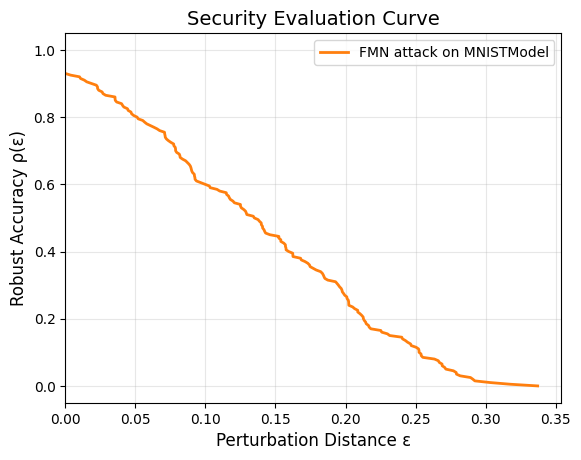

In [546]:
plt.plot(
    adv_dist_unique,
    adv_robust_acc,
    label=f"FMN attack on MNISTModel",
    color="tab:orange",
    linewidth=2,
)
plt.xlabel("Perturbation Distance ε", fontsize=12)
plt.ylabel("Robust Accuracy ρ(ε)", fontsize=12)
plt.title("Security Evaluation Curve", fontsize=14)
plt.ylim(-0.05, 1.05)
plt.xlim(left=0)
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

```{bibliography}
:filter: docname in docnames
```